In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import utils
from torchvision.transforms import v2 as transforms
from torchvision import models
from torchvision.models import ResNet18_Weights, ResNet50_Weights
from PIL import Image
import pandas as pd
import os
from matplotlib import pyplot as plt
import numpy as np
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
from torchvision.io.image import decode_jpeg, read_file
import matplotlib.pyplot as plt
import torchvision.utils as vutils

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# Data Loaders

### Dataset for Returning Image and Class

In [3]:
class CustomDataset(Dataset):
    def __init__(self, csv_file, image_dir, transform=None, classification=True):
        self.data = pd.read_csv(csv_file)
        self.image_dir = image_dir
        self.transform = transform
        self.classification = classification
        bins = [18, 28, 40]
       # Add a 'label' column to the DataFrame
        self.data['label'] = self.data['real_age'].astype(float)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        img_path = os.path.join(self.image_dir, row['file_name'])+'_face.jpg'
        label = row['label']

        # Load image
        #image = Image.open(img_path).convert('RGB')  # Load RGB
        image = decode_jpeg(read_file(img_path), device="cpu").to(device)
        image = image.float() / image.max() # 255.0 # try normalising by max value in image
        # Apply transformations
        if self.transform:
            image = self.transform(image)

        return image, label

### Transformations for Data Augmentation and Normalisation

In [4]:
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.RandomResizedCrop(size=(224, 224), scale=(0.8,1.0)),
    transforms.GaussianBlur(kernel_size=3.0, sigma=(0.1, 1)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

### Create Dataset from CSV

In [5]:
train_csv = 'appa-real-release/cropped_train.csv'
val_csv = 'appa-real-release/cropped_valid.csv'
test_csv = 'appa-real-release/cropped_test.csv'

train_dir = 'appa-real-release/cropped_train'
val_dir = 'appa-real-release/cropped_valid'
test_dir = 'appa-real-release/cropped_test'


# Create datasets
train_dataset = CustomDataset(csv_file=train_csv, image_dir=train_dir, transform=train_transforms, classification=True)
val_dataset = CustomDataset(csv_file=val_csv, image_dir=val_dir, transform=val_transforms, classification=True)
test_dataset = CustomDataset(csv_file=test_csv, image_dir=test_dir, transform=test_transforms, classification=True)

In [6]:
print(f"Train Dataset Size: {len(train_dataset)}")
print(f"Val Dataset Size: {len(val_dataset)}")
print(f"Test Dataset Size: {len(test_dataset)}")

Train Dataset Size: 3920
Val Dataset Size: 1438
Test Dataset Size: 1828


### Creating Loaders

In [7]:
# Create DataLoaders
train_loader = DataLoader(
    train_dataset,
    batch_size=128,
    shuffle=True
)
val_loader = DataLoader(
    val_dataset,
    batch_size=128,
    shuffle=False
)
test_loader = DataLoader(
    test_dataset,
    batch_size=128,
    shuffle=False
)

### Display Batches

Images batch shape: torch.Size([128, 3, 224, 224])
Labels batch shape: torch.Size([128])
Image Classes: tensor([40., 28., 46., 30., 44., 32., 22., 25., 14., 57., 20., 27., 63., 15.,
        26., 20., 58., 24., 20., 23., 60., 20., 31., 37., 23., 43., 24., 17.,
        23., 19., 19., 32.,  4., 26., 16., 29., 46., 57.,  5., 42., 60., 28.,
        28., 32.,  6., 25., 26., 23., 84., 30., 51., 25., 31.,  1., 30., 46.,
        60., 43., 57., 19., 33., 23.,  2., 59., 18., 37., 30., 19., 42., 18.,
        18., 32., 30., 21., 47., 67., 49., 37., 26., 29., 25., 45., 32., 15.,
        77., 50., 26.,  2., 21., 65.,  1., 33., 26., 23., 32., 33., 35., 36.,
        23., 19., 32.,  2., 26., 21., 15.,  1., 25., 36., 22., 50., 44., 21.,
         2., 32., 22., 48., 27., 51., 26., 41., 15., 38.,  8., 70., 25., 22.,
        43., 30.], device='cuda:0', dtype=torch.float64)


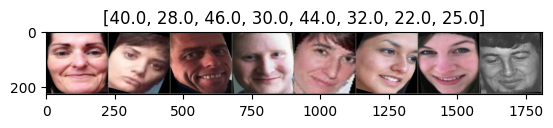

In [8]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = vutils.make_grid(inp)  
    inp = inp.permute(1, 2, 0) 
    
    # Convert mean and std to PyTorch tensors
    mean = torch.tensor([0.485, 0.456, 0.406], device=inp.device)
    std = torch.tensor([0.229, 0.224, 0.225], device=inp.device)
    
    # Normalize the image
    inp = std * inp + mean
    inp = torch.clamp(inp, 0, 1)  # Ensure values are within [0, 1]
    
    # Convert the tensor to a NumPy array for visualization
    inp = inp.cpu().numpy()

    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

# Get one batch of data
data_iter = iter(train_loader)  
images, labels = next(data_iter) 
images, labels = images.to(device), labels.to(device)

print(f"Images batch shape: {images.shape}")
print(f"Labels batch shape: {labels.shape}")
print(f"Image Classes: {labels}")

n = 8

# Make a grid from batch
out = images[:n]  # Take the first 'n' images

imshow(out, title=[x.item() for x in labels[:n]])


# Model Training

## Using Pytorch pretrained ResNet model - trained on ImageNet

In [9]:
model = models.resnet50(weights=ResNet50_Weights.DEFAULT)
num_features = model.fc.in_features 
print(f"Number of features from pre-trained model {num_features}")

# This is just for logging during training
if num_features == 512:
    resnet_arch = 'ResNet18'
elif num_features ==2048:
    resnet_arch = 'ResNet50'
else:
    resnet_arch = 'other'

Number of features from pre-trained model 2048


### Add a fully connected layer
- Freeze weights for existing parameters of pretrained model
    - These dont need retrained since we are doing transfer learning
- Add a fully connected linear layer
    - This maps from the output of the pretrained model (512 for ResNet-18 / 2048 for ResNet-50)
    - To the output we want for our classifier (1 - the probability of being a certain class)
- The weights in this layer will be trained to fit our data

In [21]:
train_on_l4 = False
# Freeze the layers in the pre-trained model
for param in model.parameters():
    param.requires_grad = True
    
# Unfreeze all residual blocks in the fourth layer
# For resnet-18 that is 2 blocks, for resnet50 that is 3 blocks
if train_on_l4:
    for name, param in model.layer4.named_parameters(): 
        print(name)
        param.requires_grad = True
        train_on_l4 = True
    
# Add a fully connected linear layer which transforms from 512 -> 1
model.fc = nn.Linear(num_features, 1)

for param in model.fc.parameters():
    param.requires_grad = True


# This is just to store a string for saving the model after training
print("\nSetup:")
if train_on_l4:
    train_type = 'fc+layer4'
else:
    train_type = 'fc'

print(train_type)
print(resnet_arch)


Setup:
fc
ResNet50


In [22]:
def count_parameters(model):
    total_params = 0
    trainable_params = 0
    
    layer_params = {
        'Conv1': sum(p.numel() for p in model.conv1.parameters()),
        'BN1': sum(p.numel() for p in model.bn1.parameters()),
        'Layer1': sum(p.numel() for p in model.layer1.parameters()),
        'Layer2': sum(p.numel() for p in model.layer2.parameters()),
        'Layer3': sum(p.numel() for p in model.layer3.parameters()),
        'Layer4': sum(p.numel() for p in model.layer4.parameters()),
        'FC': sum(p.numel() for p in model.fc.parameters())
    }
    
    for name, params in layer_params.items():
        total_params += params
        print(f"{name} Parameters: {params:,}")
    
    print(f"\nTotal Parameters: {total_params:,}")
    return layer_params

layer_params = count_parameters(model)

print(f"Number of Learnable Parameters:  {sum([param.numel() for param in model.parameters() if param.requires_grad==True]):,}")

Conv1 Parameters: 9,408
BN1 Parameters: 128
Layer1 Parameters: 215,808
Layer2 Parameters: 1,219,584
Layer3 Parameters: 7,098,368
Layer4 Parameters: 14,964,736
FC Parameters: 2,049

Total Parameters: 23,510,081
Number of Learnable Parameters:  23,510,081


In [12]:
def unfreeze_layers(model, i):
    # Unfreeze specified layers
    layers = [model.layer1, model.layer2, model.layer3, model.layer4]
    for param in layers[i].parameters():
        param.requires_grad = True    

    print(f"Number of Learnable Parameters:  {sum([param.numel() for param in model.parameters() if param.requires_grad==True]):,}")

### Train and Test functions

In [25]:
def train(model, device, train_loader, optimizer, criterion, epoch, writer, verbose=0):

    model.train()
    epoch_loss = 0 # Keep track of total loss over this epoch
    if verbose:
        print('Train')
    for batch_idx, (data, target) in enumerate(train_loader):

        data, target = data.float().to(device), target.float().to(device)

        optimizer.zero_grad()
        
        # Forward Pass
        output = model(data).squeeze()

        # Compute Loss
        loss = criterion(output, target) 
        
        if verbose:
            print(f"Batch {batch_idx}: Loss = {loss:.4f}")
        epoch_loss += loss.item()
        
        # Backwards pass and optimisation
        loss.backward()
        optimizer.step()
        
        if batch_idx % 10 == 0 and not verbose:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.4f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

    avg_loss = epoch_loss / len(train_loader)
    if verbose:
        print(f"Avg loss = {epoch_loss:.4f} / {len(train_loader)} = {avg_loss:.4f}")

    writer.add_scalar('Train', epoch_loss / len(train_loader), epoch)

In [26]:
def val(model, device, val_loader, criterion, epoch, writer, verbose=0):
    model.eval()  # Set model to evaluation mode
    val_loss = 0
    correct = 0
    
    with torch.no_grad():
        for i, (data, target) in enumerate(val_loader):
            data, target = data.float().to(device), target.float().to(device)
            output = model(data).squeeze()
            
            # Compute loss
            batch_loss = criterion(output, target).item()
            
            if verbose == 1:
                print(f"Batch {i}: Loss = {batch_loss:.4f}")
                
            val_loss += batch_loss

            # Count as correct if it within 5 years of target
            correct += (torch.abs(output - target) <= 5).sum().item()

    # Average the val loss over the entire dataset
    avg_loss = val_loss/len(val_loader)

    
    # Print results
    print('\nValidation set: Average loss: {:.4f}, Accuracy (within 5 years): {}/{} ({:.0f}%)\n'.format(
        avg_loss, correct, len(val_loader.dataset),
        100. * correct / len(val_loader.dataset)))
    
    writer.add_scalars('Val', {
        'Loss': avg_loss,
        'Accuracy': correct / len(val_loader.dataset)
    }, epoch)
    return val_loss

In [27]:
%reload_ext tensorboard

In [28]:
model = model.to(device)
criterion = nn.MSELoss()
parameter_version = 'v2'
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001)
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.1)

# optimizer = optim.SGD(model.parameters(), lr=0.001)

now = datetime.now()
log_dir = "./logs/regression/" + now.strftime("%Y%m%d-%H%M%S-") + resnet_arch +"_allLayers_"+ parameter_version+ "/"
writer = SummaryWriter(log_dir=log_dir, comment='Training Logs')

for epoch in range(1, 50 + 1):
    
    train(model, device, train_loader, optimizer, criterion, epoch, writer)
    val_loss = val(model, device, val_loader, criterion, epoch, writer)
    #scheduler.step(val_loss)

writer.close()

Train Epoch: 1 [0/3920 (0%)]	Loss: 1277.4606
Train Epoch: 1 [1280/3920 (32%)]	Loss: 285.0652
Train Epoch: 1 [2560/3920 (65%)]	Loss: 155.7421
Train Epoch: 1 [2400/3920 (97%)]	Loss: 161.1182

Validation set: Average loss: 197.8160, Accuracy (within 5 years): 440/1438 (31%)

Train Epoch: 2 [0/3920 (0%)]	Loss: 147.3829
Train Epoch: 2 [1280/3920 (32%)]	Loss: 155.2218
Train Epoch: 2 [2560/3920 (65%)]	Loss: 148.6525
Train Epoch: 2 [2400/3920 (97%)]	Loss: 140.5518

Validation set: Average loss: 189.3974, Accuracy (within 5 years): 430/1438 (30%)

Train Epoch: 3 [0/3920 (0%)]	Loss: 131.3259
Train Epoch: 3 [1280/3920 (32%)]	Loss: 111.8987
Train Epoch: 3 [2560/3920 (65%)]	Loss: 99.7747
Train Epoch: 3 [2400/3920 (97%)]	Loss: 124.8601

Validation set: Average loss: 117.0073, Accuracy (within 5 years): 578/1438 (40%)

Train Epoch: 4 [0/3920 (0%)]	Loss: 93.6658
Train Epoch: 4 [1280/3920 (32%)]	Loss: 82.2901
Train Epoch: 4 [2560/3920 (65%)]	Loss: 93.8575
Train Epoch: 4 [2400/3920 (97%)]	Loss: 94.2728


KeyboardInterrupt: 

In [29]:
torch.save(model.state_dict(), "./models/regression/"  + resnet_arch +"_" + "full" + "_" + now.strftime("%Y-%m-%d") + "_" +parameter_version+ ".pth")
print("Saved model to ./models/regression/"  + resnet_arch +"_" + now.strftime("%Y-%m-%d") + "_" + parameter_version +".pth")

Saved model to ./models/regression/ResNet50_2025-02-12_v2.pth


In [30]:
%tensorboard --logdir=./logs/regression --host localhost --port 6006

# Test Evaluation

In [25]:
def test(model, device, test_loader, criterion):
    model.eval()  # Set model to evaluation mode
    test_loss = 0
    correct = 0
    
    with torch.no_grad():
        for i, (data, target) in enumerate(val_loader):
            data, target = data.to(device), target.to(device)
            output = model(data) # Raw logits for each class. e.g. [..., ..., ..., ...]
            
            # Compute loss
            # Cross entropy loss of raw logits and target class
            batch_loss = criterion(output, target).item()

            test_loss += batch_loss
            
            # Apply softmax to get prediction
            probs = torch.softmax(output,dim=1)
            pred = probs.argmax(dim=1)
            
            # Update correct count (compare predictions to target)
            correct += pred.eq(target).sum().item()

    # Average the val loss over the entire dataset
    test_loss /= len(test_loader)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    
    return test_loss, test_accuracy

In [26]:
test_loss, test_accuracy = test(model, device, test_loader, criterion)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

Test Loss: 1.4143, Test Accuracy: 41.9037


# Visualise Predictions

In [27]:
def visualize_model(model, num_images=6, show_fails=False):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            output = model(inputs).float()

            for j in range(inputs.size()[0]):                  
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'Predicted: {output[j].item():.3f}. Ground Truth: {labels[j].item()}.')
                print(f'Confidence / Model Output: {output[j].item():.3f}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

0/1 - High confidence, ~0.5 - Low confidence
Confidence / Model Output: 27.404


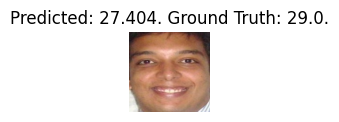

Confidence / Model Output: 24.133


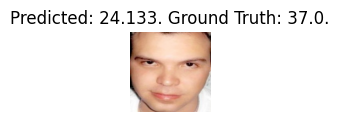

Confidence / Model Output: 9.024


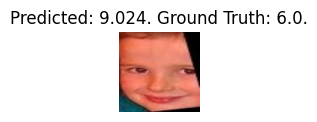

Confidence / Model Output: 24.699


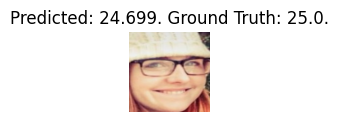

Confidence / Model Output: 21.805


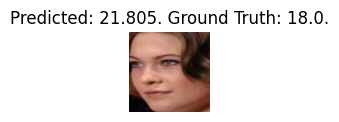

Confidence / Model Output: 35.606


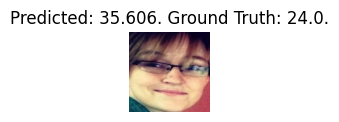

Confidence / Model Output: 10.585


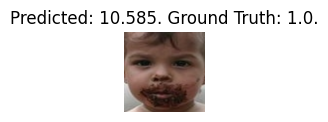

Confidence / Model Output: 31.848


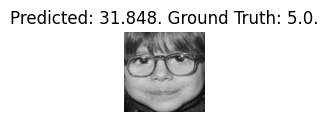

In [29]:
print('0/1 - High confidence, ~0.5 - Low confidence')
print('='*50)
visualize_model(model, num_images=8)